# Trilateration Using Least Squares

## Test Data Generation
Script is to provide some test data for the trilateration algorithm.

The first section generates a random grid of shots, assigns some FBP value with some error. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

#create sample points
dataX = pd.DataFrame(np.random.randint(0,50000,size=(1000,1)), columns=list('X'))
dataY = pd.DataFrame(np.random.randint(0,50000,size=(1000,1)), columns=list('Y'))
dataZ = pd.DataFrame(np.random.randint(-7,-5,size=(1000,1)), columns=list('Z'))
error = pd.DataFrame(np.random.randint(-30,30,size=(1000,1)), columns=list('E'))
data = pd.concat([dataX, dataY, dataZ, error], axis=1, sort=False)

#intial and target values
Xi=20054.0
Yi=25076.0
Zi=-1403.0
Si=1535.0 


#distances to intial point with error
data['fbp'] = ((((data['X']-Xi)**2 + (data['Y']-Yi)**2 + (data['Z']-Zi)**2)**0.5)+(data['E']))/(Si + data['E'])

data.head()


,X,Y,Z,E,fbp
0,29310,22334,-7,-10,6.389522
1,38123,5440,-6,14,17.259535
2,16989,37288,-6,-5,8.276485
3,4077,13498,-6,-26,13.091087
4,12834,39667,-7,27,10.477820


## Finding The Calculated Position
The next section calculates the final actual point where the FBP falls by scaling.

In [2]:
#calculate the observed distance
data['observed_dist']=(data['fbp']*Si)

#calculated ranges
data['calc_ranges']=((data['X']-Xi)**2 + (data['Y']-Yi)**2 + (data['Z']-Zi)**2)**0.5

#scaling
data['scale']=data['observed_dist']/data['calc_ranges']

#diffs
data['diff_X']= data['X']-Xi
data['diff_Y']= data['Y']-Yi
data['diff_Z']= data['Z']-Zi

#scaling
data['diff_X_scaled']= (data['X']-Xi)*data['scale']
data['diff_Y_scaled']= (data['Y']-Yi)*data['scale']
data['diff_Z_scaled']= (data['Z']-Zi)*data['scale']

#Final
data['final_X']= -data['diff_X_scaled']+data['X']
data['final_Y']= -data['diff_Y_scaled']+data['Y']
data['final_Z']= -data['diff_Z_scaled']+data['Z']

#Final_Diff
data['final_diff']=((data['final_X']-Xi)**2 + (data['final_Y']-Yi)**2 + (data['final_Z']-Zi)**2)**0.5


data.head()

,X,Y,Z,E,fbp,observed_dist,calc_ranges,scale,diff_X,diff_Y,diff_Z,diff_X_scaled,diff_Y_scaled,diff_Z_scaled,final_X,final_Y,final_Z,final_diff
0,29310,22334,-7,-10,6.389522,9807.915721,9754.020504,1.005525,9256.0,-2742.0,1396.0,9307.143436,-2757.150746,1403.713509,20002.856564,25091.150746,-1410.713509,53.895216
1,38123,5440,-6,14,17.259535,26493.385695,26721.019180,0.991481,18069.0,-19636.0,1397.0,17915.072135,-19468.723030,1385.099107,20207.927865,24908.723030,-1391.099107,227.633485
2,16989,37288,-6,-5,8.276485,12704.404290,12668.021866,1.002872,-3065.0,12212.0,1397.0,-3073.802647,12247.072734,1401.012169,20062.802647,25040.927266,-1407.012169,36.382424
3,4077,13498,-6,-26,13.091087,20094.818766,19780.450500,1.015893,-15977.0,-11578.0,1397.0,-16230.920495,-11762.007729,1419.202349,20307.920495,25260.007729,-1425.202349,314.368266
4,12834,39667,-7,27,10.477820,16083.453111,16339.354241,0.984338,-7220.0,14591.0,1396.0,-7106.922939,14362.480970,1374.136347,19940.922939,25304.519030,-1381.136347,255.901130


## Filtering
As can be seen the final offset from the observed FBP to the calulated point is normally distributed. This provides some opportunities for filtering and optimising the least squares attempt. 

There are also some possibilities of filtering on distance from the point based on the calculated ranges. Closer ranges should be given a higher weighting.

In [3]:
data['final_diff'].hist()

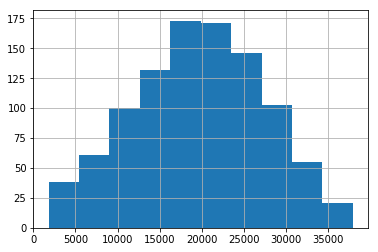

In [4]:
data['calc_ranges'].hist()

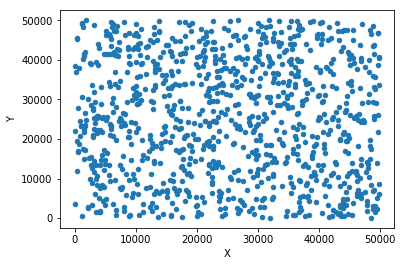

In [5]:
data.plot.scatter('X', 'Y')

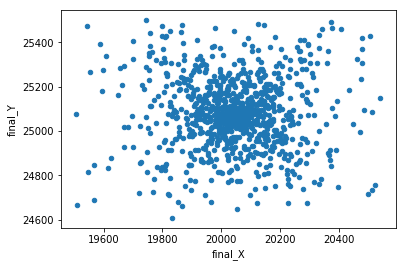

In [6]:
data.plot.scatter('final_X', 'final_Y')

Showing the effects of filtering on the data.

In [7]:
filter = data.sort_values(by=['final_diff','calc_ranges'])
filter = filter.head(500)
filter = filter.astype('float64', copy=False)

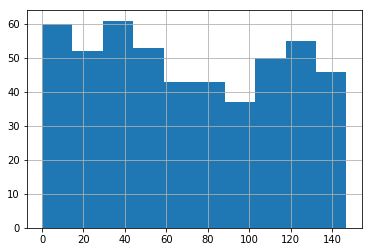

In [8]:
filter['final_diff'].hist()

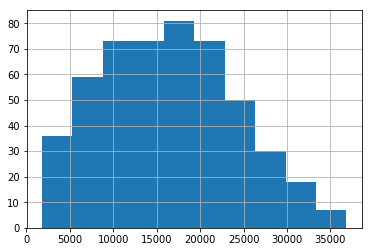

In [9]:
filter['calc_ranges'].hist()

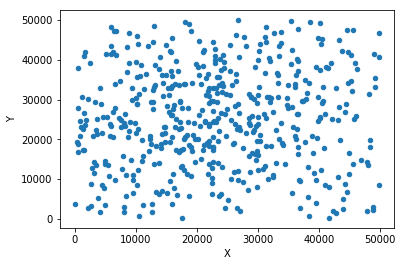

In [10]:
filter.plot.scatter('X', 'Y')

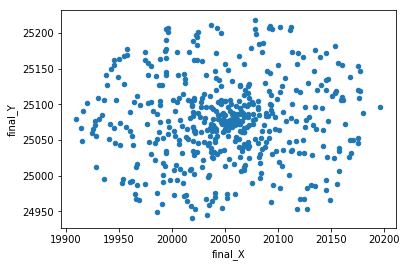

In [11]:
filter.plot.scatter('final_X', 'final_Y')

## Creating Least Squares Equations
This is currently not needed but included here for reference.

In [12]:
text_file = open("equations.py", "w")


print("def equations( guess ):", file=text_file)
print("\tx, y, z, r = guess", file=text_file)
print("\treturn (", file=text_file)

i=0

while i < len(filter.index):
    print("\t\t(x - x_",i,")**2 + (y - y_",i,")**2 + (z - z_",i,")**2 - (r_",i," - r )**2,", sep="", file=text_file)
  
    i=i+1
print("\t)",file=text_file)    
    
text_file.close()

## Create Variables
Create variables required for the equations.

In [13]:
i=0
while i < len(filter.index):
    globals()['x_%s' % i] = filter.iloc[i]['X']
    globals()['y_%s' % i] = filter.iloc[i]['Y']
    globals()['z_%s' % i] = filter.iloc[i]['Z']
    globals()['r_%s' % i] = filter.iloc[i]['observed_dist']
    i = i+1

    
    

## Hard coded equations
Since it is not possible (YET!) to get the equations imported from equations.py the below are hard coded. 

In [14]:
#from equations import equations
def equations( guess ):
	x, y, z, r = guess
	return (
		(x - x_0)**2 + (y - y_0)**2 + (z - z_0)**2 - (r_0 - r )**2,
		(x - x_1)**2 + (y - y_1)**2 + (z - z_1)**2 - (r_1 - r )**2,
		(x - x_2)**2 + (y - y_2)**2 + (z - z_2)**2 - (r_2 - r )**2,
		(x - x_3)**2 + (y - y_3)**2 + (z - z_3)**2 - (r_3 - r )**2,
		(x - x_4)**2 + (y - y_4)**2 + (z - z_4)**2 - (r_4 - r )**2,
		(x - x_5)**2 + (y - y_5)**2 + (z - z_5)**2 - (r_5 - r )**2,
		(x - x_6)**2 + (y - y_6)**2 + (z - z_6)**2 - (r_6 - r )**2,
		(x - x_7)**2 + (y - y_7)**2 + (z - z_7)**2 - (r_7 - r )**2,
		(x - x_8)**2 + (y - y_8)**2 + (z - z_8)**2 - (r_8 - r )**2,
		(x - x_9)**2 + (y - y_9)**2 + (z - z_9)**2 - (r_9 - r )**2,
		(x - x_10)**2 + (y - y_10)**2 + (z - z_10)**2 - (r_10 - r )**2,
		(x - x_11)**2 + (y - y_11)**2 + (z - z_11)**2 - (r_11 - r )**2,
		(x - x_12)**2 + (y - y_12)**2 + (z - z_12)**2 - (r_12 - r )**2,
		(x - x_13)**2 + (y - y_13)**2 + (z - z_13)**2 - (r_13 - r )**2,
		(x - x_14)**2 + (y - y_14)**2 + (z - z_14)**2 - (r_14 - r )**2,
		(x - x_15)**2 + (y - y_15)**2 + (z - z_15)**2 - (r_15 - r )**2,
		(x - x_16)**2 + (y - y_16)**2 + (z - z_16)**2 - (r_16 - r )**2,
		(x - x_17)**2 + (y - y_17)**2 + (z - z_17)**2 - (r_17 - r )**2,
		(x - x_18)**2 + (y - y_18)**2 + (z - z_18)**2 - (r_18 - r )**2,
		(x - x_19)**2 + (y - y_19)**2 + (z - z_19)**2 - (r_19 - r )**2,
		(x - x_20)**2 + (y - y_20)**2 + (z - z_20)**2 - (r_20 - r )**2,
		(x - x_21)**2 + (y - y_21)**2 + (z - z_21)**2 - (r_21 - r )**2,
		(x - x_22)**2 + (y - y_22)**2 + (z - z_22)**2 - (r_22 - r )**2,
		(x - x_23)**2 + (y - y_23)**2 + (z - z_23)**2 - (r_23 - r )**2,
		(x - x_24)**2 + (y - y_24)**2 + (z - z_24)**2 - (r_24 - r )**2,
		(x - x_25)**2 + (y - y_25)**2 + (z - z_25)**2 - (r_25 - r )**2,
		(x - x_26)**2 + (y - y_26)**2 + (z - z_26)**2 - (r_26 - r )**2,
		(x - x_27)**2 + (y - y_27)**2 + (z - z_27)**2 - (r_27 - r )**2,
		(x - x_28)**2 + (y - y_28)**2 + (z - z_28)**2 - (r_28 - r )**2,
		(x - x_29)**2 + (y - y_29)**2 + (z - z_29)**2 - (r_29 - r )**2,
		(x - x_30)**2 + (y - y_30)**2 + (z - z_30)**2 - (r_30 - r )**2,
		(x - x_31)**2 + (y - y_31)**2 + (z - z_31)**2 - (r_31 - r )**2,
		(x - x_32)**2 + (y - y_32)**2 + (z - z_32)**2 - (r_32 - r )**2,
		(x - x_33)**2 + (y - y_33)**2 + (z - z_33)**2 - (r_33 - r )**2,
		(x - x_34)**2 + (y - y_34)**2 + (z - z_34)**2 - (r_34 - r )**2,
		(x - x_35)**2 + (y - y_35)**2 + (z - z_35)**2 - (r_35 - r )**2,
		(x - x_36)**2 + (y - y_36)**2 + (z - z_36)**2 - (r_36 - r )**2,
		(x - x_37)**2 + (y - y_37)**2 + (z - z_37)**2 - (r_37 - r )**2,
		(x - x_38)**2 + (y - y_38)**2 + (z - z_38)**2 - (r_38 - r )**2,
		(x - x_39)**2 + (y - y_39)**2 + (z - z_39)**2 - (r_39 - r )**2,
		(x - x_40)**2 + (y - y_40)**2 + (z - z_40)**2 - (r_40 - r )**2,
		(x - x_41)**2 + (y - y_41)**2 + (z - z_41)**2 - (r_41 - r )**2,
		(x - x_42)**2 + (y - y_42)**2 + (z - z_42)**2 - (r_42 - r )**2,
		(x - x_43)**2 + (y - y_43)**2 + (z - z_43)**2 - (r_43 - r )**2,
		(x - x_44)**2 + (y - y_44)**2 + (z - z_44)**2 - (r_44 - r )**2,
		(x - x_45)**2 + (y - y_45)**2 + (z - z_45)**2 - (r_45 - r )**2,
		(x - x_46)**2 + (y - y_46)**2 + (z - z_46)**2 - (r_46 - r )**2,
		(x - x_47)**2 + (y - y_47)**2 + (z - z_47)**2 - (r_47 - r )**2,
		(x - x_48)**2 + (y - y_48)**2 + (z - z_48)**2 - (r_48 - r )**2,
		(x - x_49)**2 + (y - y_49)**2 + (z - z_49)**2 - (r_49 - r )**2,
		(x - x_50)**2 + (y - y_50)**2 + (z - z_50)**2 - (r_50 - r )**2,
		(x - x_51)**2 + (y - y_51)**2 + (z - z_51)**2 - (r_51 - r )**2,
		(x - x_52)**2 + (y - y_52)**2 + (z - z_52)**2 - (r_52 - r )**2,
		(x - x_53)**2 + (y - y_53)**2 + (z - z_53)**2 - (r_53 - r )**2,
		(x - x_54)**2 + (y - y_54)**2 + (z - z_54)**2 - (r_54 - r )**2,
		(x - x_55)**2 + (y - y_55)**2 + (z - z_55)**2 - (r_55 - r )**2,
		(x - x_56)**2 + (y - y_56)**2 + (z - z_56)**2 - (r_56 - r )**2,
		(x - x_57)**2 + (y - y_57)**2 + (z - z_57)**2 - (r_57 - r )**2,
		(x - x_58)**2 + (y - y_58)**2 + (z - z_58)**2 - (r_58 - r )**2,
		(x - x_59)**2 + (y - y_59)**2 + (z - z_59)**2 - (r_59 - r )**2,
		(x - x_60)**2 + (y - y_60)**2 + (z - z_60)**2 - (r_60 - r )**2,
		(x - x_61)**2 + (y - y_61)**2 + (z - z_61)**2 - (r_61 - r )**2,
		(x - x_62)**2 + (y - y_62)**2 + (z - z_62)**2 - (r_62 - r )**2,
		(x - x_63)**2 + (y - y_63)**2 + (z - z_63)**2 - (r_63 - r )**2,
		(x - x_64)**2 + (y - y_64)**2 + (z - z_64)**2 - (r_64 - r )**2,
		(x - x_65)**2 + (y - y_65)**2 + (z - z_65)**2 - (r_65 - r )**2,
		(x - x_66)**2 + (y - y_66)**2 + (z - z_66)**2 - (r_66 - r )**2,
		(x - x_67)**2 + (y - y_67)**2 + (z - z_67)**2 - (r_67 - r )**2,
		(x - x_68)**2 + (y - y_68)**2 + (z - z_68)**2 - (r_68 - r )**2,
		(x - x_69)**2 + (y - y_69)**2 + (z - z_69)**2 - (r_69 - r )**2,
		(x - x_70)**2 + (y - y_70)**2 + (z - z_70)**2 - (r_70 - r )**2,
		(x - x_71)**2 + (y - y_71)**2 + (z - z_71)**2 - (r_71 - r )**2,
		(x - x_72)**2 + (y - y_72)**2 + (z - z_72)**2 - (r_72 - r )**2,
		(x - x_73)**2 + (y - y_73)**2 + (z - z_73)**2 - (r_73 - r )**2,
		(x - x_74)**2 + (y - y_74)**2 + (z - z_74)**2 - (r_74 - r )**2,
		(x - x_75)**2 + (y - y_75)**2 + (z - z_75)**2 - (r_75 - r )**2,
		(x - x_76)**2 + (y - y_76)**2 + (z - z_76)**2 - (r_76 - r )**2,
		(x - x_77)**2 + (y - y_77)**2 + (z - z_77)**2 - (r_77 - r )**2,
		(x - x_78)**2 + (y - y_78)**2 + (z - z_78)**2 - (r_78 - r )**2,
		(x - x_79)**2 + (y - y_79)**2 + (z - z_79)**2 - (r_79 - r )**2,
		(x - x_80)**2 + (y - y_80)**2 + (z - z_80)**2 - (r_80 - r )**2,
		(x - x_81)**2 + (y - y_81)**2 + (z - z_81)**2 - (r_81 - r )**2,
		(x - x_82)**2 + (y - y_82)**2 + (z - z_82)**2 - (r_82 - r )**2,
		(x - x_83)**2 + (y - y_83)**2 + (z - z_83)**2 - (r_83 - r )**2,
		(x - x_84)**2 + (y - y_84)**2 + (z - z_84)**2 - (r_84 - r )**2,
		(x - x_85)**2 + (y - y_85)**2 + (z - z_85)**2 - (r_85 - r )**2,
		(x - x_86)**2 + (y - y_86)**2 + (z - z_86)**2 - (r_86 - r )**2,
		(x - x_87)**2 + (y - y_87)**2 + (z - z_87)**2 - (r_87 - r )**2,
		(x - x_88)**2 + (y - y_88)**2 + (z - z_88)**2 - (r_88 - r )**2,
		(x - x_89)**2 + (y - y_89)**2 + (z - z_89)**2 - (r_89 - r )**2,
		(x - x_90)**2 + (y - y_90)**2 + (z - z_90)**2 - (r_90 - r )**2,
		(x - x_91)**2 + (y - y_91)**2 + (z - z_91)**2 - (r_91 - r )**2,
		(x - x_92)**2 + (y - y_92)**2 + (z - z_92)**2 - (r_92 - r )**2,
		(x - x_93)**2 + (y - y_93)**2 + (z - z_93)**2 - (r_93 - r )**2,
		(x - x_94)**2 + (y - y_94)**2 + (z - z_94)**2 - (r_94 - r )**2,
		(x - x_95)**2 + (y - y_95)**2 + (z - z_95)**2 - (r_95 - r )**2,
		(x - x_96)**2 + (y - y_96)**2 + (z - z_96)**2 - (r_96 - r )**2,
		(x - x_97)**2 + (y - y_97)**2 + (z - z_97)**2 - (r_97 - r )**2,
		(x - x_98)**2 + (y - y_98)**2 + (z - z_98)**2 - (r_98 - r )**2,
		(x - x_99)**2 + (y - y_99)**2 + (z - z_99)**2 - (r_99 - r )**2,
		(x - x_100)**2 + (y - y_100)**2 + (z - z_100)**2 - (r_100 - r )**2,
		(x - x_101)**2 + (y - y_101)**2 + (z - z_101)**2 - (r_101 - r )**2,
		(x - x_102)**2 + (y - y_102)**2 + (z - z_102)**2 - (r_102 - r )**2,
		(x - x_103)**2 + (y - y_103)**2 + (z - z_103)**2 - (r_103 - r )**2,
		(x - x_104)**2 + (y - y_104)**2 + (z - z_104)**2 - (r_104 - r )**2,
		(x - x_105)**2 + (y - y_105)**2 + (z - z_105)**2 - (r_105 - r )**2,
		(x - x_106)**2 + (y - y_106)**2 + (z - z_106)**2 - (r_106 - r )**2,
		(x - x_107)**2 + (y - y_107)**2 + (z - z_107)**2 - (r_107 - r )**2,
		(x - x_108)**2 + (y - y_108)**2 + (z - z_108)**2 - (r_108 - r )**2,
		(x - x_109)**2 + (y - y_109)**2 + (z - z_109)**2 - (r_109 - r )**2,
		(x - x_110)**2 + (y - y_110)**2 + (z - z_110)**2 - (r_110 - r )**2,
		(x - x_111)**2 + (y - y_111)**2 + (z - z_111)**2 - (r_111 - r )**2,
		(x - x_112)**2 + (y - y_112)**2 + (z - z_112)**2 - (r_112 - r )**2,
		(x - x_113)**2 + (y - y_113)**2 + (z - z_113)**2 - (r_113 - r )**2,
		(x - x_114)**2 + (y - y_114)**2 + (z - z_114)**2 - (r_114 - r )**2,
		(x - x_115)**2 + (y - y_115)**2 + (z - z_115)**2 - (r_115 - r )**2,
		(x - x_116)**2 + (y - y_116)**2 + (z - z_116)**2 - (r_116 - r )**2,
		(x - x_117)**2 + (y - y_117)**2 + (z - z_117)**2 - (r_117 - r )**2,
		(x - x_118)**2 + (y - y_118)**2 + (z - z_118)**2 - (r_118 - r )**2,
		(x - x_119)**2 + (y - y_119)**2 + (z - z_119)**2 - (r_119 - r )**2,
		(x - x_120)**2 + (y - y_120)**2 + (z - z_120)**2 - (r_120 - r )**2,
		(x - x_121)**2 + (y - y_121)**2 + (z - z_121)**2 - (r_121 - r )**2,
		(x - x_122)**2 + (y - y_122)**2 + (z - z_122)**2 - (r_122 - r )**2,
		(x - x_123)**2 + (y - y_123)**2 + (z - z_123)**2 - (r_123 - r )**2,
		(x - x_124)**2 + (y - y_124)**2 + (z - z_124)**2 - (r_124 - r )**2,
		(x - x_125)**2 + (y - y_125)**2 + (z - z_125)**2 - (r_125 - r )**2,
		(x - x_126)**2 + (y - y_126)**2 + (z - z_126)**2 - (r_126 - r )**2,
		(x - x_127)**2 + (y - y_127)**2 + (z - z_127)**2 - (r_127 - r )**2,
		(x - x_128)**2 + (y - y_128)**2 + (z - z_128)**2 - (r_128 - r )**2,
		(x - x_129)**2 + (y - y_129)**2 + (z - z_129)**2 - (r_129 - r )**2,
		(x - x_130)**2 + (y - y_130)**2 + (z - z_130)**2 - (r_130 - r )**2,
		(x - x_131)**2 + (y - y_131)**2 + (z - z_131)**2 - (r_131 - r )**2,
		(x - x_132)**2 + (y - y_132)**2 + (z - z_132)**2 - (r_132 - r )**2,
		(x - x_133)**2 + (y - y_133)**2 + (z - z_133)**2 - (r_133 - r )**2,
		(x - x_134)**2 + (y - y_134)**2 + (z - z_134)**2 - (r_134 - r )**2,
		(x - x_135)**2 + (y - y_135)**2 + (z - z_135)**2 - (r_135 - r )**2,
		(x - x_136)**2 + (y - y_136)**2 + (z - z_136)**2 - (r_136 - r )**2,
		(x - x_137)**2 + (y - y_137)**2 + (z - z_137)**2 - (r_137 - r )**2,
		(x - x_138)**2 + (y - y_138)**2 + (z - z_138)**2 - (r_138 - r )**2,
		(x - x_139)**2 + (y - y_139)**2 + (z - z_139)**2 - (r_139 - r )**2,
		(x - x_140)**2 + (y - y_140)**2 + (z - z_140)**2 - (r_140 - r )**2,
		(x - x_141)**2 + (y - y_141)**2 + (z - z_141)**2 - (r_141 - r )**2,
		(x - x_142)**2 + (y - y_142)**2 + (z - z_142)**2 - (r_142 - r )**2,
		(x - x_143)**2 + (y - y_143)**2 + (z - z_143)**2 - (r_143 - r )**2,
		(x - x_144)**2 + (y - y_144)**2 + (z - z_144)**2 - (r_144 - r )**2,
		(x - x_145)**2 + (y - y_145)**2 + (z - z_145)**2 - (r_145 - r )**2,
		(x - x_146)**2 + (y - y_146)**2 + (z - z_146)**2 - (r_146 - r )**2,
		(x - x_147)**2 + (y - y_147)**2 + (z - z_147)**2 - (r_147 - r )**2,
		(x - x_148)**2 + (y - y_148)**2 + (z - z_148)**2 - (r_148 - r )**2,
		(x - x_149)**2 + (y - y_149)**2 + (z - z_149)**2 - (r_149 - r )**2,
		(x - x_150)**2 + (y - y_150)**2 + (z - z_150)**2 - (r_150 - r )**2,
		(x - x_151)**2 + (y - y_151)**2 + (z - z_151)**2 - (r_151 - r )**2,
		(x - x_152)**2 + (y - y_152)**2 + (z - z_152)**2 - (r_152 - r )**2,
		(x - x_153)**2 + (y - y_153)**2 + (z - z_153)**2 - (r_153 - r )**2,
		(x - x_154)**2 + (y - y_154)**2 + (z - z_154)**2 - (r_154 - r )**2,
		(x - x_155)**2 + (y - y_155)**2 + (z - z_155)**2 - (r_155 - r )**2,
		(x - x_156)**2 + (y - y_156)**2 + (z - z_156)**2 - (r_156 - r )**2,
		(x - x_157)**2 + (y - y_157)**2 + (z - z_157)**2 - (r_157 - r )**2,
		(x - x_158)**2 + (y - y_158)**2 + (z - z_158)**2 - (r_158 - r )**2,
		(x - x_159)**2 + (y - y_159)**2 + (z - z_159)**2 - (r_159 - r )**2,
		(x - x_160)**2 + (y - y_160)**2 + (z - z_160)**2 - (r_160 - r )**2,
		(x - x_161)**2 + (y - y_161)**2 + (z - z_161)**2 - (r_161 - r )**2,
		(x - x_162)**2 + (y - y_162)**2 + (z - z_162)**2 - (r_162 - r )**2,
		(x - x_163)**2 + (y - y_163)**2 + (z - z_163)**2 - (r_163 - r )**2,
		(x - x_164)**2 + (y - y_164)**2 + (z - z_164)**2 - (r_164 - r )**2,
		(x - x_165)**2 + (y - y_165)**2 + (z - z_165)**2 - (r_165 - r )**2,
		(x - x_166)**2 + (y - y_166)**2 + (z - z_166)**2 - (r_166 - r )**2,
		(x - x_167)**2 + (y - y_167)**2 + (z - z_167)**2 - (r_167 - r )**2,
		(x - x_168)**2 + (y - y_168)**2 + (z - z_168)**2 - (r_168 - r )**2,
		(x - x_169)**2 + (y - y_169)**2 + (z - z_169)**2 - (r_169 - r )**2,
		(x - x_170)**2 + (y - y_170)**2 + (z - z_170)**2 - (r_170 - r )**2,
		(x - x_171)**2 + (y - y_171)**2 + (z - z_171)**2 - (r_171 - r )**2,
		(x - x_172)**2 + (y - y_172)**2 + (z - z_172)**2 - (r_172 - r )**2,
		(x - x_173)**2 + (y - y_173)**2 + (z - z_173)**2 - (r_173 - r )**2,
		(x - x_174)**2 + (y - y_174)**2 + (z - z_174)**2 - (r_174 - r )**2,
		(x - x_175)**2 + (y - y_175)**2 + (z - z_175)**2 - (r_175 - r )**2,
		(x - x_176)**2 + (y - y_176)**2 + (z - z_176)**2 - (r_176 - r )**2,
		(x - x_177)**2 + (y - y_177)**2 + (z - z_177)**2 - (r_177 - r )**2,
		(x - x_178)**2 + (y - y_178)**2 + (z - z_178)**2 - (r_178 - r )**2,
		(x - x_179)**2 + (y - y_179)**2 + (z - z_179)**2 - (r_179 - r )**2,
		(x - x_180)**2 + (y - y_180)**2 + (z - z_180)**2 - (r_180 - r )**2,
		(x - x_181)**2 + (y - y_181)**2 + (z - z_181)**2 - (r_181 - r )**2,
		(x - x_182)**2 + (y - y_182)**2 + (z - z_182)**2 - (r_182 - r )**2,
		(x - x_183)**2 + (y - y_183)**2 + (z - z_183)**2 - (r_183 - r )**2,
		(x - x_184)**2 + (y - y_184)**2 + (z - z_184)**2 - (r_184 - r )**2,
		(x - x_185)**2 + (y - y_185)**2 + (z - z_185)**2 - (r_185 - r )**2,
		(x - x_186)**2 + (y - y_186)**2 + (z - z_186)**2 - (r_186 - r )**2,
		(x - x_187)**2 + (y - y_187)**2 + (z - z_187)**2 - (r_187 - r )**2,
		(x - x_188)**2 + (y - y_188)**2 + (z - z_188)**2 - (r_188 - r )**2,
		(x - x_189)**2 + (y - y_189)**2 + (z - z_189)**2 - (r_189 - r )**2,
		(x - x_190)**2 + (y - y_190)**2 + (z - z_190)**2 - (r_190 - r )**2,
		(x - x_191)**2 + (y - y_191)**2 + (z - z_191)**2 - (r_191 - r )**2,
		(x - x_192)**2 + (y - y_192)**2 + (z - z_192)**2 - (r_192 - r )**2,
		(x - x_193)**2 + (y - y_193)**2 + (z - z_193)**2 - (r_193 - r )**2,
		(x - x_194)**2 + (y - y_194)**2 + (z - z_194)**2 - (r_194 - r )**2,
		(x - x_195)**2 + (y - y_195)**2 + (z - z_195)**2 - (r_195 - r )**2,
		(x - x_196)**2 + (y - y_196)**2 + (z - z_196)**2 - (r_196 - r )**2,
		(x - x_197)**2 + (y - y_197)**2 + (z - z_197)**2 - (r_197 - r )**2,
		(x - x_198)**2 + (y - y_198)**2 + (z - z_198)**2 - (r_198 - r )**2,
		(x - x_199)**2 + (y - y_199)**2 + (z - z_199)**2 - (r_199 - r )**2,
		(x - x_200)**2 + (y - y_200)**2 + (z - z_200)**2 - (r_200 - r )**2,
		(x - x_201)**2 + (y - y_201)**2 + (z - z_201)**2 - (r_201 - r )**2,
		(x - x_202)**2 + (y - y_202)**2 + (z - z_202)**2 - (r_202 - r )**2,
		(x - x_203)**2 + (y - y_203)**2 + (z - z_203)**2 - (r_203 - r )**2,
		(x - x_204)**2 + (y - y_204)**2 + (z - z_204)**2 - (r_204 - r )**2,
		(x - x_205)**2 + (y - y_205)**2 + (z - z_205)**2 - (r_205 - r )**2,
		(x - x_206)**2 + (y - y_206)**2 + (z - z_206)**2 - (r_206 - r )**2,
		(x - x_207)**2 + (y - y_207)**2 + (z - z_207)**2 - (r_207 - r )**2,
		(x - x_208)**2 + (y - y_208)**2 + (z - z_208)**2 - (r_208 - r )**2,
		(x - x_209)**2 + (y - y_209)**2 + (z - z_209)**2 - (r_209 - r )**2,
		(x - x_210)**2 + (y - y_210)**2 + (z - z_210)**2 - (r_210 - r )**2,
		(x - x_211)**2 + (y - y_211)**2 + (z - z_211)**2 - (r_211 - r )**2,
		(x - x_212)**2 + (y - y_212)**2 + (z - z_212)**2 - (r_212 - r )**2,
		(x - x_213)**2 + (y - y_213)**2 + (z - z_213)**2 - (r_213 - r )**2,
		(x - x_214)**2 + (y - y_214)**2 + (z - z_214)**2 - (r_214 - r )**2,
		(x - x_215)**2 + (y - y_215)**2 + (z - z_215)**2 - (r_215 - r )**2,
		(x - x_216)**2 + (y - y_216)**2 + (z - z_216)**2 - (r_216 - r )**2,
		(x - x_217)**2 + (y - y_217)**2 + (z - z_217)**2 - (r_217 - r )**2,
		(x - x_218)**2 + (y - y_218)**2 + (z - z_218)**2 - (r_218 - r )**2,
		(x - x_219)**2 + (y - y_219)**2 + (z - z_219)**2 - (r_219 - r )**2,
		(x - x_220)**2 + (y - y_220)**2 + (z - z_220)**2 - (r_220 - r )**2,
		(x - x_221)**2 + (y - y_221)**2 + (z - z_221)**2 - (r_221 - r )**2,
		(x - x_222)**2 + (y - y_222)**2 + (z - z_222)**2 - (r_222 - r )**2,
		(x - x_223)**2 + (y - y_223)**2 + (z - z_223)**2 - (r_223 - r )**2,
		(x - x_224)**2 + (y - y_224)**2 + (z - z_224)**2 - (r_224 - r )**2,
		(x - x_225)**2 + (y - y_225)**2 + (z - z_225)**2 - (r_225 - r )**2,
		(x - x_226)**2 + (y - y_226)**2 + (z - z_226)**2 - (r_226 - r )**2,
		(x - x_227)**2 + (y - y_227)**2 + (z - z_227)**2 - (r_227 - r )**2,
		(x - x_228)**2 + (y - y_228)**2 + (z - z_228)**2 - (r_228 - r )**2,
		(x - x_229)**2 + (y - y_229)**2 + (z - z_229)**2 - (r_229 - r )**2,
		(x - x_230)**2 + (y - y_230)**2 + (z - z_230)**2 - (r_230 - r )**2,
		(x - x_231)**2 + (y - y_231)**2 + (z - z_231)**2 - (r_231 - r )**2,
		(x - x_232)**2 + (y - y_232)**2 + (z - z_232)**2 - (r_232 - r )**2,
		(x - x_233)**2 + (y - y_233)**2 + (z - z_233)**2 - (r_233 - r )**2,
		(x - x_234)**2 + (y - y_234)**2 + (z - z_234)**2 - (r_234 - r )**2,
		(x - x_235)**2 + (y - y_235)**2 + (z - z_235)**2 - (r_235 - r )**2,
		(x - x_236)**2 + (y - y_236)**2 + (z - z_236)**2 - (r_236 - r )**2,
		(x - x_237)**2 + (y - y_237)**2 + (z - z_237)**2 - (r_237 - r )**2,
		(x - x_238)**2 + (y - y_238)**2 + (z - z_238)**2 - (r_238 - r )**2,
		(x - x_239)**2 + (y - y_239)**2 + (z - z_239)**2 - (r_239 - r )**2,
		(x - x_240)**2 + (y - y_240)**2 + (z - z_240)**2 - (r_240 - r )**2,
		(x - x_241)**2 + (y - y_241)**2 + (z - z_241)**2 - (r_241 - r )**2,
		(x - x_242)**2 + (y - y_242)**2 + (z - z_242)**2 - (r_242 - r )**2,
		(x - x_243)**2 + (y - y_243)**2 + (z - z_243)**2 - (r_243 - r )**2,
		(x - x_244)**2 + (y - y_244)**2 + (z - z_244)**2 - (r_244 - r )**2,
		(x - x_245)**2 + (y - y_245)**2 + (z - z_245)**2 - (r_245 - r )**2,
		(x - x_246)**2 + (y - y_246)**2 + (z - z_246)**2 - (r_246 - r )**2,
		(x - x_247)**2 + (y - y_247)**2 + (z - z_247)**2 - (r_247 - r )**2,
		(x - x_248)**2 + (y - y_248)**2 + (z - z_248)**2 - (r_248 - r )**2,
		(x - x_249)**2 + (y - y_249)**2 + (z - z_249)**2 - (r_249 - r )**2,
		(x - x_250)**2 + (y - y_250)**2 + (z - z_250)**2 - (r_250 - r )**2,
		(x - x_251)**2 + (y - y_251)**2 + (z - z_251)**2 - (r_251 - r )**2,
		(x - x_252)**2 + (y - y_252)**2 + (z - z_252)**2 - (r_252 - r )**2,
		(x - x_253)**2 + (y - y_253)**2 + (z - z_253)**2 - (r_253 - r )**2,
		(x - x_254)**2 + (y - y_254)**2 + (z - z_254)**2 - (r_254 - r )**2,
		(x - x_255)**2 + (y - y_255)**2 + (z - z_255)**2 - (r_255 - r )**2,
		(x - x_256)**2 + (y - y_256)**2 + (z - z_256)**2 - (r_256 - r )**2,
		(x - x_257)**2 + (y - y_257)**2 + (z - z_257)**2 - (r_257 - r )**2,
		(x - x_258)**2 + (y - y_258)**2 + (z - z_258)**2 - (r_258 - r )**2,
		(x - x_259)**2 + (y - y_259)**2 + (z - z_259)**2 - (r_259 - r )**2,
		(x - x_260)**2 + (y - y_260)**2 + (z - z_260)**2 - (r_260 - r )**2,
		(x - x_261)**2 + (y - y_261)**2 + (z - z_261)**2 - (r_261 - r )**2,
		(x - x_262)**2 + (y - y_262)**2 + (z - z_262)**2 - (r_262 - r )**2,
		(x - x_263)**2 + (y - y_263)**2 + (z - z_263)**2 - (r_263 - r )**2,
		(x - x_264)**2 + (y - y_264)**2 + (z - z_264)**2 - (r_264 - r )**2,
		(x - x_265)**2 + (y - y_265)**2 + (z - z_265)**2 - (r_265 - r )**2,
		(x - x_266)**2 + (y - y_266)**2 + (z - z_266)**2 - (r_266 - r )**2,
		(x - x_267)**2 + (y - y_267)**2 + (z - z_267)**2 - (r_267 - r )**2,
		(x - x_268)**2 + (y - y_268)**2 + (z - z_268)**2 - (r_268 - r )**2,
		(x - x_269)**2 + (y - y_269)**2 + (z - z_269)**2 - (r_269 - r )**2,
		(x - x_270)**2 + (y - y_270)**2 + (z - z_270)**2 - (r_270 - r )**2,
		(x - x_271)**2 + (y - y_271)**2 + (z - z_271)**2 - (r_271 - r )**2,
		(x - x_272)**2 + (y - y_272)**2 + (z - z_272)**2 - (r_272 - r )**2,
		(x - x_273)**2 + (y - y_273)**2 + (z - z_273)**2 - (r_273 - r )**2,
		(x - x_274)**2 + (y - y_274)**2 + (z - z_274)**2 - (r_274 - r )**2,
		(x - x_275)**2 + (y - y_275)**2 + (z - z_275)**2 - (r_275 - r )**2,
		(x - x_276)**2 + (y - y_276)**2 + (z - z_276)**2 - (r_276 - r )**2,
		(x - x_277)**2 + (y - y_277)**2 + (z - z_277)**2 - (r_277 - r )**2,
		(x - x_278)**2 + (y - y_278)**2 + (z - z_278)**2 - (r_278 - r )**2,
		(x - x_279)**2 + (y - y_279)**2 + (z - z_279)**2 - (r_279 - r )**2,
		(x - x_280)**2 + (y - y_280)**2 + (z - z_280)**2 - (r_280 - r )**2,
		(x - x_281)**2 + (y - y_281)**2 + (z - z_281)**2 - (r_281 - r )**2,
		(x - x_282)**2 + (y - y_282)**2 + (z - z_282)**2 - (r_282 - r )**2,
		(x - x_283)**2 + (y - y_283)**2 + (z - z_283)**2 - (r_283 - r )**2,
		(x - x_284)**2 + (y - y_284)**2 + (z - z_284)**2 - (r_284 - r )**2,
		(x - x_285)**2 + (y - y_285)**2 + (z - z_285)**2 - (r_285 - r )**2,
		(x - x_286)**2 + (y - y_286)**2 + (z - z_286)**2 - (r_286 - r )**2,
		(x - x_287)**2 + (y - y_287)**2 + (z - z_287)**2 - (r_287 - r )**2,
		(x - x_288)**2 + (y - y_288)**2 + (z - z_288)**2 - (r_288 - r )**2,
		(x - x_289)**2 + (y - y_289)**2 + (z - z_289)**2 - (r_289 - r )**2,
		(x - x_290)**2 + (y - y_290)**2 + (z - z_290)**2 - (r_290 - r )**2,
		(x - x_291)**2 + (y - y_291)**2 + (z - z_291)**2 - (r_291 - r )**2,
		(x - x_292)**2 + (y - y_292)**2 + (z - z_292)**2 - (r_292 - r )**2,
		(x - x_293)**2 + (y - y_293)**2 + (z - z_293)**2 - (r_293 - r )**2,
		(x - x_294)**2 + (y - y_294)**2 + (z - z_294)**2 - (r_294 - r )**2,
		(x - x_295)**2 + (y - y_295)**2 + (z - z_295)**2 - (r_295 - r )**2,
		(x - x_296)**2 + (y - y_296)**2 + (z - z_296)**2 - (r_296 - r )**2,
		(x - x_297)**2 + (y - y_297)**2 + (z - z_297)**2 - (r_297 - r )**2,
		(x - x_298)**2 + (y - y_298)**2 + (z - z_298)**2 - (r_298 - r )**2,
		(x - x_299)**2 + (y - y_299)**2 + (z - z_299)**2 - (r_299 - r )**2,
		(x - x_300)**2 + (y - y_300)**2 + (z - z_300)**2 - (r_300 - r )**2,
		(x - x_301)**2 + (y - y_301)**2 + (z - z_301)**2 - (r_301 - r )**2,
		(x - x_302)**2 + (y - y_302)**2 + (z - z_302)**2 - (r_302 - r )**2,
		(x - x_303)**2 + (y - y_303)**2 + (z - z_303)**2 - (r_303 - r )**2,
		(x - x_304)**2 + (y - y_304)**2 + (z - z_304)**2 - (r_304 - r )**2,
		(x - x_305)**2 + (y - y_305)**2 + (z - z_305)**2 - (r_305 - r )**2,
		(x - x_306)**2 + (y - y_306)**2 + (z - z_306)**2 - (r_306 - r )**2,
		(x - x_307)**2 + (y - y_307)**2 + (z - z_307)**2 - (r_307 - r )**2,
		(x - x_308)**2 + (y - y_308)**2 + (z - z_308)**2 - (r_308 - r )**2,
		(x - x_309)**2 + (y - y_309)**2 + (z - z_309)**2 - (r_309 - r )**2,
		(x - x_310)**2 + (y - y_310)**2 + (z - z_310)**2 - (r_310 - r )**2,
		(x - x_311)**2 + (y - y_311)**2 + (z - z_311)**2 - (r_311 - r )**2,
		(x - x_312)**2 + (y - y_312)**2 + (z - z_312)**2 - (r_312 - r )**2,
		(x - x_313)**2 + (y - y_313)**2 + (z - z_313)**2 - (r_313 - r )**2,
		(x - x_314)**2 + (y - y_314)**2 + (z - z_314)**2 - (r_314 - r )**2,
		(x - x_315)**2 + (y - y_315)**2 + (z - z_315)**2 - (r_315 - r )**2,
		(x - x_316)**2 + (y - y_316)**2 + (z - z_316)**2 - (r_316 - r )**2,
		(x - x_317)**2 + (y - y_317)**2 + (z - z_317)**2 - (r_317 - r )**2,
		(x - x_318)**2 + (y - y_318)**2 + (z - z_318)**2 - (r_318 - r )**2,
		(x - x_319)**2 + (y - y_319)**2 + (z - z_319)**2 - (r_319 - r )**2,
		(x - x_320)**2 + (y - y_320)**2 + (z - z_320)**2 - (r_320 - r )**2,
		(x - x_321)**2 + (y - y_321)**2 + (z - z_321)**2 - (r_321 - r )**2,
		(x - x_322)**2 + (y - y_322)**2 + (z - z_322)**2 - (r_322 - r )**2,
		(x - x_323)**2 + (y - y_323)**2 + (z - z_323)**2 - (r_323 - r )**2,
		(x - x_324)**2 + (y - y_324)**2 + (z - z_324)**2 - (r_324 - r )**2,
		(x - x_325)**2 + (y - y_325)**2 + (z - z_325)**2 - (r_325 - r )**2,
		(x - x_326)**2 + (y - y_326)**2 + (z - z_326)**2 - (r_326 - r )**2,
		(x - x_327)**2 + (y - y_327)**2 + (z - z_327)**2 - (r_327 - r )**2,
		(x - x_328)**2 + (y - y_328)**2 + (z - z_328)**2 - (r_328 - r )**2,
		(x - x_329)**2 + (y - y_329)**2 + (z - z_329)**2 - (r_329 - r )**2,
		(x - x_330)**2 + (y - y_330)**2 + (z - z_330)**2 - (r_330 - r )**2,
		(x - x_331)**2 + (y - y_331)**2 + (z - z_331)**2 - (r_331 - r )**2,
		(x - x_332)**2 + (y - y_332)**2 + (z - z_332)**2 - (r_332 - r )**2,
		(x - x_333)**2 + (y - y_333)**2 + (z - z_333)**2 - (r_333 - r )**2,
		(x - x_334)**2 + (y - y_334)**2 + (z - z_334)**2 - (r_334 - r )**2,
		(x - x_335)**2 + (y - y_335)**2 + (z - z_335)**2 - (r_335 - r )**2,
		(x - x_336)**2 + (y - y_336)**2 + (z - z_336)**2 - (r_336 - r )**2,
		(x - x_337)**2 + (y - y_337)**2 + (z - z_337)**2 - (r_337 - r )**2,
		(x - x_338)**2 + (y - y_338)**2 + (z - z_338)**2 - (r_338 - r )**2,
		(x - x_339)**2 + (y - y_339)**2 + (z - z_339)**2 - (r_339 - r )**2,
		(x - x_340)**2 + (y - y_340)**2 + (z - z_340)**2 - (r_340 - r )**2,
		(x - x_341)**2 + (y - y_341)**2 + (z - z_341)**2 - (r_341 - r )**2,
		(x - x_342)**2 + (y - y_342)**2 + (z - z_342)**2 - (r_342 - r )**2,
		(x - x_343)**2 + (y - y_343)**2 + (z - z_343)**2 - (r_343 - r )**2,
		(x - x_344)**2 + (y - y_344)**2 + (z - z_344)**2 - (r_344 - r )**2,
		(x - x_345)**2 + (y - y_345)**2 + (z - z_345)**2 - (r_345 - r )**2,
		(x - x_346)**2 + (y - y_346)**2 + (z - z_346)**2 - (r_346 - r )**2,
		(x - x_347)**2 + (y - y_347)**2 + (z - z_347)**2 - (r_347 - r )**2,
		(x - x_348)**2 + (y - y_348)**2 + (z - z_348)**2 - (r_348 - r )**2,
		(x - x_349)**2 + (y - y_349)**2 + (z - z_349)**2 - (r_349 - r )**2,
		(x - x_350)**2 + (y - y_350)**2 + (z - z_350)**2 - (r_350 - r )**2,
		(x - x_351)**2 + (y - y_351)**2 + (z - z_351)**2 - (r_351 - r )**2,
		(x - x_352)**2 + (y - y_352)**2 + (z - z_352)**2 - (r_352 - r )**2,
		(x - x_353)**2 + (y - y_353)**2 + (z - z_353)**2 - (r_353 - r )**2,
		(x - x_354)**2 + (y - y_354)**2 + (z - z_354)**2 - (r_354 - r )**2,
		(x - x_355)**2 + (y - y_355)**2 + (z - z_355)**2 - (r_355 - r )**2,
		(x - x_356)**2 + (y - y_356)**2 + (z - z_356)**2 - (r_356 - r )**2,
		(x - x_357)**2 + (y - y_357)**2 + (z - z_357)**2 - (r_357 - r )**2,
		(x - x_358)**2 + (y - y_358)**2 + (z - z_358)**2 - (r_358 - r )**2,
		(x - x_359)**2 + (y - y_359)**2 + (z - z_359)**2 - (r_359 - r )**2,
		(x - x_360)**2 + (y - y_360)**2 + (z - z_360)**2 - (r_360 - r )**2,
		(x - x_361)**2 + (y - y_361)**2 + (z - z_361)**2 - (r_361 - r )**2,
		(x - x_362)**2 + (y - y_362)**2 + (z - z_362)**2 - (r_362 - r )**2,
		(x - x_363)**2 + (y - y_363)**2 + (z - z_363)**2 - (r_363 - r )**2,
		(x - x_364)**2 + (y - y_364)**2 + (z - z_364)**2 - (r_364 - r )**2,
		(x - x_365)**2 + (y - y_365)**2 + (z - z_365)**2 - (r_365 - r )**2,
		(x - x_366)**2 + (y - y_366)**2 + (z - z_366)**2 - (r_366 - r )**2,
		(x - x_367)**2 + (y - y_367)**2 + (z - z_367)**2 - (r_367 - r )**2,
		(x - x_368)**2 + (y - y_368)**2 + (z - z_368)**2 - (r_368 - r )**2,
		(x - x_369)**2 + (y - y_369)**2 + (z - z_369)**2 - (r_369 - r )**2,
		(x - x_370)**2 + (y - y_370)**2 + (z - z_370)**2 - (r_370 - r )**2,
		(x - x_371)**2 + (y - y_371)**2 + (z - z_371)**2 - (r_371 - r )**2,
		(x - x_372)**2 + (y - y_372)**2 + (z - z_372)**2 - (r_372 - r )**2,
		(x - x_373)**2 + (y - y_373)**2 + (z - z_373)**2 - (r_373 - r )**2,
		(x - x_374)**2 + (y - y_374)**2 + (z - z_374)**2 - (r_374 - r )**2,
		(x - x_375)**2 + (y - y_375)**2 + (z - z_375)**2 - (r_375 - r )**2,
		(x - x_376)**2 + (y - y_376)**2 + (z - z_376)**2 - (r_376 - r )**2,
		(x - x_377)**2 + (y - y_377)**2 + (z - z_377)**2 - (r_377 - r )**2,
		(x - x_378)**2 + (y - y_378)**2 + (z - z_378)**2 - (r_378 - r )**2,
		(x - x_379)**2 + (y - y_379)**2 + (z - z_379)**2 - (r_379 - r )**2,
		(x - x_380)**2 + (y - y_380)**2 + (z - z_380)**2 - (r_380 - r )**2,
		(x - x_381)**2 + (y - y_381)**2 + (z - z_381)**2 - (r_381 - r )**2,
		(x - x_382)**2 + (y - y_382)**2 + (z - z_382)**2 - (r_382 - r )**2,
		(x - x_383)**2 + (y - y_383)**2 + (z - z_383)**2 - (r_383 - r )**2,
		(x - x_384)**2 + (y - y_384)**2 + (z - z_384)**2 - (r_384 - r )**2,
		(x - x_385)**2 + (y - y_385)**2 + (z - z_385)**2 - (r_385 - r )**2,
		(x - x_386)**2 + (y - y_386)**2 + (z - z_386)**2 - (r_386 - r )**2,
		(x - x_387)**2 + (y - y_387)**2 + (z - z_387)**2 - (r_387 - r )**2,
		(x - x_388)**2 + (y - y_388)**2 + (z - z_388)**2 - (r_388 - r )**2,
		(x - x_389)**2 + (y - y_389)**2 + (z - z_389)**2 - (r_389 - r )**2,
		(x - x_390)**2 + (y - y_390)**2 + (z - z_390)**2 - (r_390 - r )**2,
		(x - x_391)**2 + (y - y_391)**2 + (z - z_391)**2 - (r_391 - r )**2,
		(x - x_392)**2 + (y - y_392)**2 + (z - z_392)**2 - (r_392 - r )**2,
		(x - x_393)**2 + (y - y_393)**2 + (z - z_393)**2 - (r_393 - r )**2,
		(x - x_394)**2 + (y - y_394)**2 + (z - z_394)**2 - (r_394 - r )**2,
		(x - x_395)**2 + (y - y_395)**2 + (z - z_395)**2 - (r_395 - r )**2,
		(x - x_396)**2 + (y - y_396)**2 + (z - z_396)**2 - (r_396 - r )**2,
		(x - x_397)**2 + (y - y_397)**2 + (z - z_397)**2 - (r_397 - r )**2,
		(x - x_398)**2 + (y - y_398)**2 + (z - z_398)**2 - (r_398 - r )**2,
		(x - x_399)**2 + (y - y_399)**2 + (z - z_399)**2 - (r_399 - r )**2,
		(x - x_400)**2 + (y - y_400)**2 + (z - z_400)**2 - (r_400 - r )**2,
		(x - x_401)**2 + (y - y_401)**2 + (z - z_401)**2 - (r_401 - r )**2,
		(x - x_402)**2 + (y - y_402)**2 + (z - z_402)**2 - (r_402 - r )**2,
		(x - x_403)**2 + (y - y_403)**2 + (z - z_403)**2 - (r_403 - r )**2,
		(x - x_404)**2 + (y - y_404)**2 + (z - z_404)**2 - (r_404 - r )**2,
		(x - x_405)**2 + (y - y_405)**2 + (z - z_405)**2 - (r_405 - r )**2,
		(x - x_406)**2 + (y - y_406)**2 + (z - z_406)**2 - (r_406 - r )**2,
		(x - x_407)**2 + (y - y_407)**2 + (z - z_407)**2 - (r_407 - r )**2,
		(x - x_408)**2 + (y - y_408)**2 + (z - z_408)**2 - (r_408 - r )**2,
		(x - x_409)**2 + (y - y_409)**2 + (z - z_409)**2 - (r_409 - r )**2,
		(x - x_410)**2 + (y - y_410)**2 + (z - z_410)**2 - (r_410 - r )**2,
		(x - x_411)**2 + (y - y_411)**2 + (z - z_411)**2 - (r_411 - r )**2,
		(x - x_412)**2 + (y - y_412)**2 + (z - z_412)**2 - (r_412 - r )**2,
		(x - x_413)**2 + (y - y_413)**2 + (z - z_413)**2 - (r_413 - r )**2,
		(x - x_414)**2 + (y - y_414)**2 + (z - z_414)**2 - (r_414 - r )**2,
		(x - x_415)**2 + (y - y_415)**2 + (z - z_415)**2 - (r_415 - r )**2,
		(x - x_416)**2 + (y - y_416)**2 + (z - z_416)**2 - (r_416 - r )**2,
		(x - x_417)**2 + (y - y_417)**2 + (z - z_417)**2 - (r_417 - r )**2,
		(x - x_418)**2 + (y - y_418)**2 + (z - z_418)**2 - (r_418 - r )**2,
		(x - x_419)**2 + (y - y_419)**2 + (z - z_419)**2 - (r_419 - r )**2,
		(x - x_420)**2 + (y - y_420)**2 + (z - z_420)**2 - (r_420 - r )**2,
		(x - x_421)**2 + (y - y_421)**2 + (z - z_421)**2 - (r_421 - r )**2,
		(x - x_422)**2 + (y - y_422)**2 + (z - z_422)**2 - (r_422 - r )**2,
		(x - x_423)**2 + (y - y_423)**2 + (z - z_423)**2 - (r_423 - r )**2,
		(x - x_424)**2 + (y - y_424)**2 + (z - z_424)**2 - (r_424 - r )**2,
		(x - x_425)**2 + (y - y_425)**2 + (z - z_425)**2 - (r_425 - r )**2,
		(x - x_426)**2 + (y - y_426)**2 + (z - z_426)**2 - (r_426 - r )**2,
		(x - x_427)**2 + (y - y_427)**2 + (z - z_427)**2 - (r_427 - r )**2,
		(x - x_428)**2 + (y - y_428)**2 + (z - z_428)**2 - (r_428 - r )**2,
		(x - x_429)**2 + (y - y_429)**2 + (z - z_429)**2 - (r_429 - r )**2,
		(x - x_430)**2 + (y - y_430)**2 + (z - z_430)**2 - (r_430 - r )**2,
		(x - x_431)**2 + (y - y_431)**2 + (z - z_431)**2 - (r_431 - r )**2,
		(x - x_432)**2 + (y - y_432)**2 + (z - z_432)**2 - (r_432 - r )**2,
		(x - x_433)**2 + (y - y_433)**2 + (z - z_433)**2 - (r_433 - r )**2,
		(x - x_434)**2 + (y - y_434)**2 + (z - z_434)**2 - (r_434 - r )**2,
		(x - x_435)**2 + (y - y_435)**2 + (z - z_435)**2 - (r_435 - r )**2,
		(x - x_436)**2 + (y - y_436)**2 + (z - z_436)**2 - (r_436 - r )**2,
		(x - x_437)**2 + (y - y_437)**2 + (z - z_437)**2 - (r_437 - r )**2,
		(x - x_438)**2 + (y - y_438)**2 + (z - z_438)**2 - (r_438 - r )**2,
		(x - x_439)**2 + (y - y_439)**2 + (z - z_439)**2 - (r_439 - r )**2,
		(x - x_440)**2 + (y - y_440)**2 + (z - z_440)**2 - (r_440 - r )**2,
		(x - x_441)**2 + (y - y_441)**2 + (z - z_441)**2 - (r_441 - r )**2,
		(x - x_442)**2 + (y - y_442)**2 + (z - z_442)**2 - (r_442 - r )**2,
		(x - x_443)**2 + (y - y_443)**2 + (z - z_443)**2 - (r_443 - r )**2,
		(x - x_444)**2 + (y - y_444)**2 + (z - z_444)**2 - (r_444 - r )**2,
		(x - x_445)**2 + (y - y_445)**2 + (z - z_445)**2 - (r_445 - r )**2,
		(x - x_446)**2 + (y - y_446)**2 + (z - z_446)**2 - (r_446 - r )**2,
		(x - x_447)**2 + (y - y_447)**2 + (z - z_447)**2 - (r_447 - r )**2,
		(x - x_448)**2 + (y - y_448)**2 + (z - z_448)**2 - (r_448 - r )**2,
		(x - x_449)**2 + (y - y_449)**2 + (z - z_449)**2 - (r_449 - r )**2,
		(x - x_450)**2 + (y - y_450)**2 + (z - z_450)**2 - (r_450 - r )**2,
		(x - x_451)**2 + (y - y_451)**2 + (z - z_451)**2 - (r_451 - r )**2,
		(x - x_452)**2 + (y - y_452)**2 + (z - z_452)**2 - (r_452 - r )**2,
		(x - x_453)**2 + (y - y_453)**2 + (z - z_453)**2 - (r_453 - r )**2,
		(x - x_454)**2 + (y - y_454)**2 + (z - z_454)**2 - (r_454 - r )**2,
		(x - x_455)**2 + (y - y_455)**2 + (z - z_455)**2 - (r_455 - r )**2,
		(x - x_456)**2 + (y - y_456)**2 + (z - z_456)**2 - (r_456 - r )**2,
		(x - x_457)**2 + (y - y_457)**2 + (z - z_457)**2 - (r_457 - r )**2,
		(x - x_458)**2 + (y - y_458)**2 + (z - z_458)**2 - (r_458 - r )**2,
		(x - x_459)**2 + (y - y_459)**2 + (z - z_459)**2 - (r_459 - r )**2,
		(x - x_460)**2 + (y - y_460)**2 + (z - z_460)**2 - (r_460 - r )**2,
		(x - x_461)**2 + (y - y_461)**2 + (z - z_461)**2 - (r_461 - r )**2,
		(x - x_462)**2 + (y - y_462)**2 + (z - z_462)**2 - (r_462 - r )**2,
		(x - x_463)**2 + (y - y_463)**2 + (z - z_463)**2 - (r_463 - r )**2,
		(x - x_464)**2 + (y - y_464)**2 + (z - z_464)**2 - (r_464 - r )**2,
		(x - x_465)**2 + (y - y_465)**2 + (z - z_465)**2 - (r_465 - r )**2,
		(x - x_466)**2 + (y - y_466)**2 + (z - z_466)**2 - (r_466 - r )**2,
		(x - x_467)**2 + (y - y_467)**2 + (z - z_467)**2 - (r_467 - r )**2,
		(x - x_468)**2 + (y - y_468)**2 + (z - z_468)**2 - (r_468 - r )**2,
		(x - x_469)**2 + (y - y_469)**2 + (z - z_469)**2 - (r_469 - r )**2,
		(x - x_470)**2 + (y - y_470)**2 + (z - z_470)**2 - (r_470 - r )**2,
		(x - x_471)**2 + (y - y_471)**2 + (z - z_471)**2 - (r_471 - r )**2,
		(x - x_472)**2 + (y - y_472)**2 + (z - z_472)**2 - (r_472 - r )**2,
		(x - x_473)**2 + (y - y_473)**2 + (z - z_473)**2 - (r_473 - r )**2,
		(x - x_474)**2 + (y - y_474)**2 + (z - z_474)**2 - (r_474 - r )**2,
		(x - x_475)**2 + (y - y_475)**2 + (z - z_475)**2 - (r_475 - r )**2,
		(x - x_476)**2 + (y - y_476)**2 + (z - z_476)**2 - (r_476 - r )**2,
		(x - x_477)**2 + (y - y_477)**2 + (z - z_477)**2 - (r_477 - r )**2,
		(x - x_478)**2 + (y - y_478)**2 + (z - z_478)**2 - (r_478 - r )**2,
		(x - x_479)**2 + (y - y_479)**2 + (z - z_479)**2 - (r_479 - r )**2,
		(x - x_480)**2 + (y - y_480)**2 + (z - z_480)**2 - (r_480 - r )**2,
		(x - x_481)**2 + (y - y_481)**2 + (z - z_481)**2 - (r_481 - r )**2,
		(x - x_482)**2 + (y - y_482)**2 + (z - z_482)**2 - (r_482 - r )**2,
		(x - x_483)**2 + (y - y_483)**2 + (z - z_483)**2 - (r_483 - r )**2,
		(x - x_484)**2 + (y - y_484)**2 + (z - z_484)**2 - (r_484 - r )**2,
		(x - x_485)**2 + (y - y_485)**2 + (z - z_485)**2 - (r_485 - r )**2,
		(x - x_486)**2 + (y - y_486)**2 + (z - z_486)**2 - (r_486 - r )**2,
		(x - x_487)**2 + (y - y_487)**2 + (z - z_487)**2 - (r_487 - r )**2,
		(x - x_488)**2 + (y - y_488)**2 + (z - z_488)**2 - (r_488 - r )**2,
		(x - x_489)**2 + (y - y_489)**2 + (z - z_489)**2 - (r_489 - r )**2,
		(x - x_490)**2 + (y - y_490)**2 + (z - z_490)**2 - (r_490 - r )**2,
		(x - x_491)**2 + (y - y_491)**2 + (z - z_491)**2 - (r_491 - r )**2,
		(x - x_492)**2 + (y - y_492)**2 + (z - z_492)**2 - (r_492 - r )**2,
		(x - x_493)**2 + (y - y_493)**2 + (z - z_493)**2 - (r_493 - r )**2,
		(x - x_494)**2 + (y - y_494)**2 + (z - z_494)**2 - (r_494 - r )**2,
		(x - x_495)**2 + (y - y_495)**2 + (z - z_495)**2 - (r_495 - r )**2,
		(x - x_496)**2 + (y - y_496)**2 + (z - z_496)**2 - (r_496 - r )**2,
		(x - x_497)**2 + (y - y_497)**2 + (z - z_497)**2 - (r_497 - r )**2,
		(x - x_498)**2 + (y - y_498)**2 + (z - z_498)**2 - (r_498 - r )**2,
		(x - x_499)**2 + (y - y_499)**2 + (z - z_499)**2 - (r_499 - r )**2,
	)

## Run The Least Squares

In [15]:
import scipy
from scipy.optimize import least_squares

# Make SciPy solve the system using an initial guess.
# The initial guess affects which of the "candidates" SciPy finds.
initial_guess = (Xi, Yi, Zi, 0)

#equations( initial_guess )
results = least_squares(equations, initial_guess)

results

 active_mask: array([0., 0., 0., 0.])
        cost: 2321101133922270.0
         fun: array([ 1.71200905e+04,  4.53715973e+04,  7.82728943e+04, -3.69364205e+04,
        7.91705213e+03,  2.07152974e+05,  4.16632137e+05,  4.38401677e+05,
        2.33835114e+05, -1.43258390e+05,  4.14938241e+05,  4.56225854e+05,
        7.29131813e+05,  2.43812985e+05,  1.66973314e+05,  1.88009142e+04,
       -2.21349190e+05, -3.21608759e+04,  7.17709052e+04, -4.64101465e+04,
       -1.64748611e+04,  2.43561167e+04,  3.80574568e+03, -7.48753829e+04,
       -5.26736175e+04,  5.01932289e+04,  7.38900178e+03, -2.71928282e+02,
        1.55594126e+05,  3.66036252e+05,  4.06167374e+04,  2.69903919e+05,
        1.53246374e+05,  2.32606020e+05,  4.42481683e+04,  8.74531292e+04,
        5.58118690e+05,  2.17634681e+05,  6.92385466e+04, -2.10312609e+05,
       -3.87069130e+05,  5.25830422e+05, -5.28252090e+05,  4.37814735e+04,
        6.11102359e+05,  5.04576574e+05, -4.01253888e+05,  3.06636425e+05,
        3.44840

In [16]:
#covar = (J^T J)^{-1}
import numpy as np
J = results.jac
JT = results.jac.transpose()

In [17]:
cov_matrix = pd.DataFrame((JT.dot(J))**-1)
cov_matrix

,0,1,2,3
0,2.871701e-12,4.703005e-11,1.137066e-10,-5.695446e-12
1,4.703005e-11,3.343750e-12,1.417462e-09,-1.683947e-10
2,1.137066e-10,1.417462e-09,2.567679e-10,-2.195624e-11
3,-5.695446e-12,-1.683947e-10,-2.195624e-11,1.535738e-12


In [18]:
cov_mat_xy = cov_matrix.drop([2,3], 1)
cov_mat_xy = cov_mat_xy.drop([2,3], 0)
cov_mat_xy

#http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/

,0,1
0,2.871701e-12,4.703005e-11
1,4.703005e-11,3.343750e-12


In [19]:
from numpy import linalg as LA

LA.eig(cov_mat_xy)

(array([-4.39229151e-11,  5.01383664e-11]), array([[-0.70887888, -0.70533023],
        [ 0.70533023, -0.70887888]]))

In [20]:
print(results.x[0]-Xi,"metres diff in x")
print(results.x[1]-Yi,"metres diff in y")
print(results.x[2]-Zi,"metres diff in z")

-3.3359369638601493 metres diff in x
-8.199300830197899 metres diff in y
1.0468283777111083 metres diff in z
